In [1]:
from asap.util.io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
from asap.data.dataloader import DataSet
from asap.util import topics
from asap.annotation import ASAPNMF
import asapc
import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc
from sklearn.preprocessing import StandardScaler
# import logging


experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sample_in = args.home + args.experiment + args.input+ args.sample_id +'/'+args.sample_id
sample_out = args.home + args.experiment + args.output+ args.sample_id +'/'+args.sample_id



tree_max_depth = 8
num_factors = 10
batch_size = 10000
batch_iteration = 1


dl = DataSet(sample_in,sample_out)
sample_list = dl.get_samplenames()
dl.initialize_data(sample_list,batch_size)


print(dl.inpath)
print(dl.outpath)


/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/pbmc/pbmc
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/pbmc/pbmc


In [2]:
model = np.load(sample_out+'_dcnmf.npz')

In [3]:
df_beta = pd.DataFrame(model['beta'].T)
# df_beta.columns = [x for x in dl.genes]
df_theta = pd.DataFrame(model['corr'])
df_theta.index = dl.barcodes

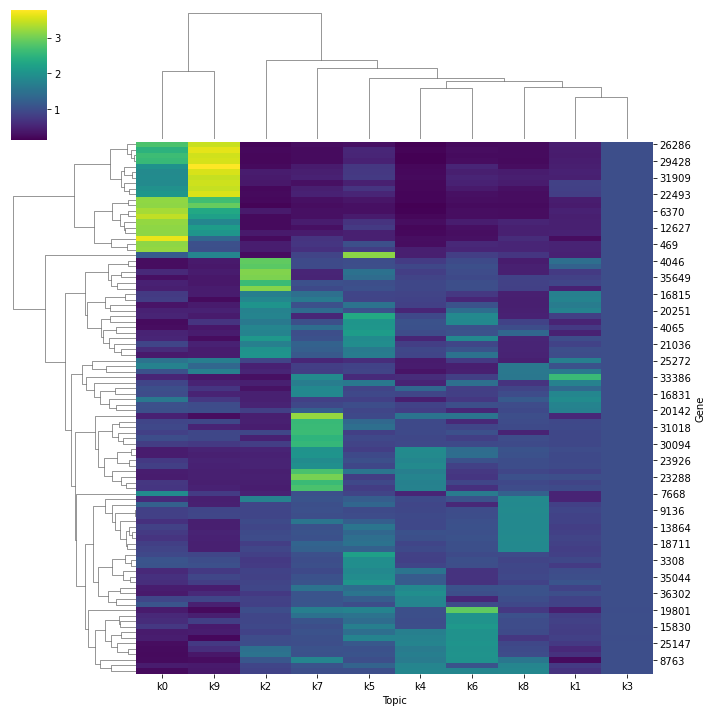

In [4]:
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=10)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
# df_top[df_top>20] = 20
sns.clustermap(df_top.T,cmap='viridis')

In [5]:
import umap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df_umap= pd.DataFrame()
df_umap['cell'] = dl.barcodes
# df_umap['topic_bulk'] = [x for x in df_theta.iloc[:,:].idxmax(axis=1)]

scaler = StandardScaler()
scaled = scaler.fit_transform(df_theta.to_numpy())
kmeans = KMeans(n_clusters=10, init='k-means++',random_state=0).fit(scaled)
df_umap['topic_bulk'] = kmeans.labels_

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.99,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

# df_umap = pd.read_csv(sample_out+'_theta_umap.csv')
# df_umap.columns = ['cell','umap1','umap2']


,cell,topic_bulk,umap1,umap2
0,AAACATACAACCAC-1_3k_3k,3,14.524982,10.279009
1,AAACATTGAGCTAC-1_3k_3k,7,7.719608,-3.646490
2,AAACATTGATCAGC-1_3k_3k,0,12.323812,6.468115
3,AAACCGTGCTTCCG-1_3k_3k,4,-4.350681,0.601085
4,AAACCGTGTATGCG-1_3k_3k,5,11.774078,-1.082663
...,...,...,...,...
7035,TTTGGTTTCGCTAGCG-1_4k_4k,6,-4.503521,5.571290
7036,TTTGTCACACTTAACG-1_4k_4k,2,6.479798,5.676091
7037,TTTGTCACAGGTCCAC-1_4k_4k,0,7.347774,9.708047
7038,TTTGTCAGTTAAGACA-1_4k_4k,9,2.012760,-8.314276


Text(0, 0.5, 'UMAP2')

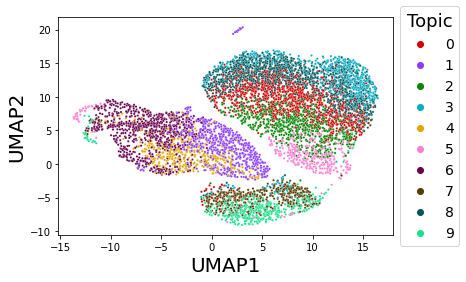

In [6]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=5,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
# p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

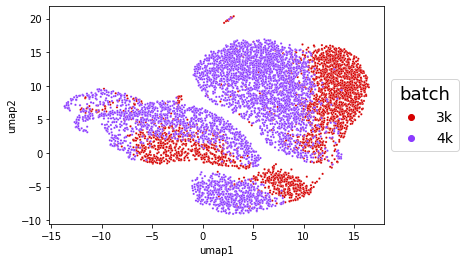

In [7]:
df_umap['batch'] = [x.split('_')[1]for x in df_umap['cell']]
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['batch'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='batch',s=5,palette=cp,legend=True)
plt.legend(title='batch',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))

In [8]:
df_pl = pd.read_csv(dl.outpath+'_scanpy.csv.gz')
df_pl = df_pl[['cell','leiden']]
# df_pl = df_pl.loc[:,['Unnamed: 0','celltype_major']]
df_pl.columns = ['cell','cell_type']
df_pl['cell'] = [x.split('_')[0] for x in df_umap['cell']]
df_umap['cell'] = [x.split('_')[0] for x in df_umap['cell']]
df_umap = pd.merge(df_umap,df_pl[['cell','cell_type']],on='cell',how='left')
df_umap

,cell,topic_bulk,umap1,umap2,batch,cell_type
0,AAACATACAACCAC-1,3,14.524982,10.279009,3k,0
1,AAACATTGAGCTAC-1,7,7.719608,-3.646490,3k,2
2,AAACATTGATCAGC-1,0,12.323812,6.468115,3k,1
3,AAACCGTGCTTCCG-1,4,-4.350681,0.601085,3k,5
4,AAACCGTGTATGCG-1,5,11.774078,-1.082663,3k,6
...,...,...,...,...,...,...
7035,TTTGGTTTCGCTAGCG-1,6,-4.503521,5.571290,4k,3
7036,TTTGTCACACTTAACG-1,2,6.479798,5.676091,4k,6
7037,TTTGTCACAGGTCCAC-1,0,7.347774,9.708047,4k,6
7038,TTTGTCAGTTAAGACA-1,9,2.012760,-8.314276,4k,2


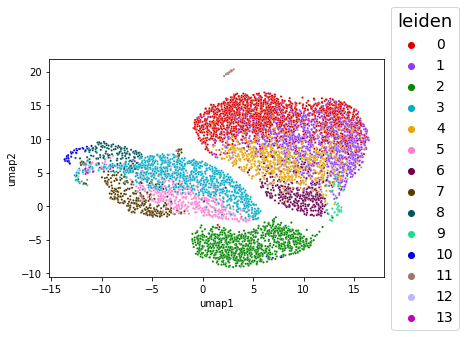

In [9]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['cell_type'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='cell_type',s=5,palette=cp,legend=True)
plt.legend(title='leiden',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))

In [10]:
df_match = df_umap[['cell','cell_type','topic_bulk']]
df_match = df_match.groupby(['cell_type','topic_bulk']).count().reset_index()
df_match = df_match.pivot('cell_type','topic_bulk')
df_match = df_match.fillna(0)
df_match

cell                                                          \
topic_bulk      0      1      2      3      4      5      6      7      8   
cell_type                                                                   
0           421.0    0.0   39.0  393.0    0.0    0.0    0.0    3.0  897.0   
1           374.0    0.0  149.0  205.0    1.0   24.0    0.0   12.0  346.0   
2            26.0    0.0   10.0   43.0    0.0   13.0    0.0  445.0   10.0   
3             0.0  492.0    0.0    0.0   32.0    0.0  346.0    3.0    0.0   
4           308.0    0.0  409.0   27.0    0.0   41.0    0.0    9.0   82.0   
5             0.0   76.0    0.0    0.0  357.0    0.0   48.0    3.0    0.0   
6            28.0    0.0  112.0    0.0    0.0  225.0    1.0    0.0    4.0   
7             0.0   29.0    0.0    0.0   77.0    0.0  181.0    3.0    0.0   
8             0.0    3.0    0.0    0.0    5.0    0.0  138.0    1.0    0.0   
9             1.0    0.0    3.0    1.0    0.0   33.0    0.0    2.0    0.0   
10            0.0    0.0    0.0    0.0    0.0   35.0    2.0    0.0    0.0   
11            0.0   22.0    0.0    0.0    0.0    1.0    5.0    0.0    0.0   
12            0.0    0.0    0.0    0.0    1.0    0.0   16.0    1.0    0.0   
13            0.0    0.0    0.0    0.0    0.0    1.0   13.0    0.0    0.0   

                   
topic_bulk      9  
cell_type          
0             0.0  
1             5.0  
2           418.0  
3            11.0  
4             1.0  
5             0.0  
6             0.0  
7             3.0  
8             4.0  
9             3.0  
10            4.0  
11            1.0  
12            2.0  
13            0.0

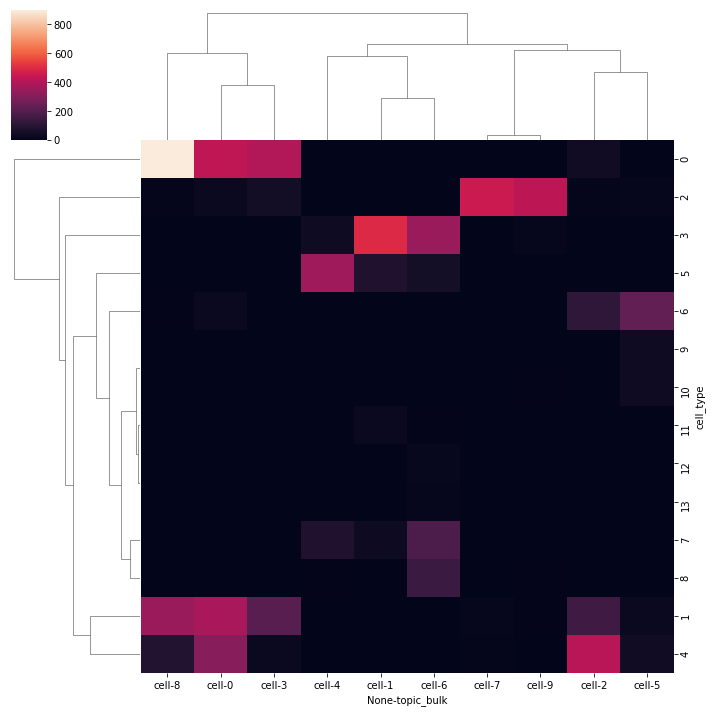

In [11]:
sns.clustermap(df_match)

In [12]:
from sklearn.metrics import normalized_mutual_info_score

normalized_mutual_info_score(df_umap['cell_type'].values,df_umap['topic_bulk'].values)

0.5209938539722947